### Lecture 3: Novelty functions for onset detection

In this example, we consider some of the commonly used novelty functions for onset detection, plotting them together with sound samples with human annotations for onsets. Using these plots, we will be discussing the behaviour of various novelty functions. 
In cell 3, you are expected to implement spectral flux defined as:
$$
SF_t = \sum_{k=0}^{N/2} H( |X_t[k]| - |X_{(t-1)}[k])| )
$$
where H(x) is the half-wave rectifier function:
$$
H(x) = \frac{x+|x|}{2}
$$


In [1]:
#Downloading samples from ODB database: 
# https://grfia.dlsi.ua.es/cm/worklines/pertusa/onset/ODB/
import urllib.request
import os, sys

targetDir = '../data/onset/'
if not os.path.exists(targetDir):
    os.mkdir(targetDir)

waveDir = 'https://grfia.dlsi.ua.es/cm/worklines/pertusa/onset/ODB/sounds/'
annotationDir = 'https://grfia.dlsi.ua.es/cm/worklines/pertusa/onset/ODB/ground-truth/'
wavFileNames = ['25-rujero.wav','RM-C036.wav','3-you_think_too_muchb.wav','tiersen11.wav']

for file in wavFileNames:
    #Downlaoding wave and annotation files
    urllib.request.urlretrieve(waveDir + file, file)
    annotFile = file.replace('.wav','.txt')
    urllib.request.urlretrieve(annotationDir + annotFile, annotFile)
    #moving files to '../data/onset/'
    os.rename(file,targetDir + file)
    os.rename(annotFile,targetDir + annotFile)

print('Data downloaded in: ', targetDir)

Data downloaded in:  ../data/onset/


In [2]:
#Imports and initializations
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from essentia.standard import *
import os
fs = 44100
durInSecs = 5
t = np.arange(durInSecs * fs) / float(fs)
windowSize = 2048
hopSize = 512

In [3]:
#Novelty function computation function definitions
def spectral_flux(x, windowSize, hopSize, winType = "hann"):
    w = Windowing(type = winType)
    spectrum = Spectrum(size = windowSize)

    #Your code starts here
    # You can refer to the next function 'highFreqCompDeviation' for amplitude spectrum computation
    prevAmpSpec = np.zeros((1 + int(windowSize / 2),))
    sf = []
    for frame in FrameGenerator(x, frameSize = windowSize, hopSize = hopSize):
        ampSpec = spectrum(w(frame))
        specDiff = ampSpec - prevAmpSpec
        h = (specDiff + np.abs(specDiff)) / 2
        sf.append(np.sum(h))
        prevAmpSpec = ampSpec
    SF = np.array(sf[1:])#discard the first dummy value
    #Your code ends here
    return SF

def highFreqCont(x, windowSize, hopSize, winType = "hann"):
    w = Windowing(type = winType)
    spectrum = Spectrum(size = windowSize)

    hfc = []
    for frame in FrameGenerator(x, frameSize = windowSize, hopSize = hopSize):
        ampSpec = spectrum(w(frame))
        hfc.append(np.dot(np.power(ampSpec,2),np.arange(ampSpec.size)))
    hfc = np.array(hfc)
    #While High frequency content could be directly used, 
    #one may also prefer to compute the derivative and half-wave rectify it
    #hfc_dev = hfc[1:] - hfc[:-1]#derivative
    #hfc_dev = (hfc_dev + np.abs(hfc_dev)) / 2 #half-wave rectification
    return hfc

def energy_deviation(x, windowSize, hopSize, winType = "hann"):
    w = Windowing(type = winType)
    energy = Energy()
    NRG = []
    for frame in FrameGenerator(x, frameSize = windowSize, hopSize = hopSize):
        NRG.append(np.log10(energy(w(frame))+np.finfo(float).eps))
    NRG = np.array(NRG)
    NRG_dev = NRG[1:] - NRG[:-1]
    NRG_dev = (NRG_dev + np.abs(NRG_dev)) / 2#half-wave rectification
    NRG_dev = NRG_dev / max(NRG_dev)#normalisation
    NRG_dev[NRG_dev < 0.01] = 0.01#rectification before the log operation
    NRG_dev = np.log10(NRG_dev)
    return NRG_dev
def pitch_deviation(x,windowSize,hopSize):
    #F0 estimation using Essentia
    run_predominant_melody = PitchMelodia(guessUnvoiced = True,frameSize = windowSize, hopSize = hopSize);
    f0_hz, confidence = run_predominant_melody(x)
    f0_hz[confidence < 0.1] = 0.1#avoid 0, there is a log operation below
    #Conversion to cents
    A4_hz = 440;#reference frequency
    f0_cents = np.log2(f0_hz / A4_hz) * 1200;
    f0_dev = np.abs(f0_cents[1:] - f0_cents[:-1])
    f0_dev[f0_dev > 200] = 100#this is to avoid large pitch changes dominating small changes
    return f0_dev

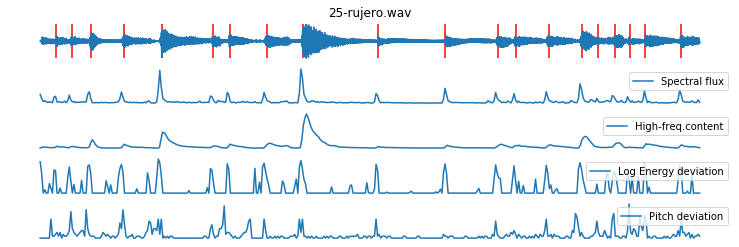

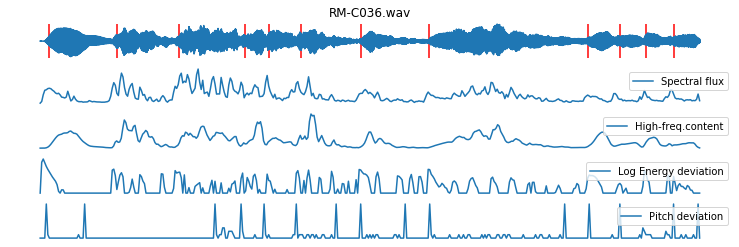

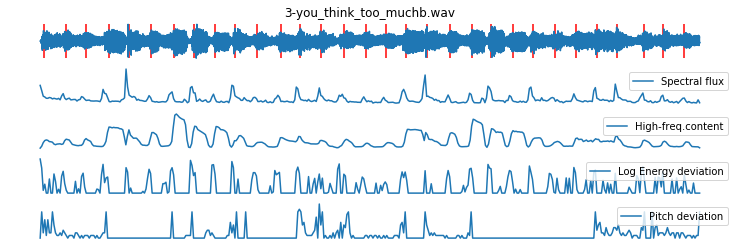

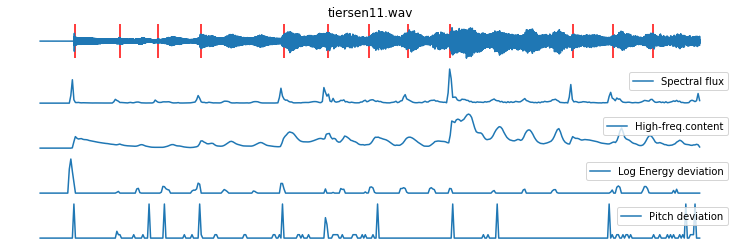

In [4]:
targetDir = '../data/onset/'
wavFileNames = ['25-rujero.wav', 'RM-C036.wav', '3-you_think_too_muchb.wav', 'tiersen11.wav']
ind = 0
for file in wavFileNames:
    fileName = os.path.join(targetDir, file)
    x = MonoLoader(filename = fileName, sampleRate = fs)()
    x = x[:durInSecs * fs]#let's use only the first two seconds of the signals
    x = x / np.max(np.abs(x))
    SF = spectral_flux(x,windowSize, hopSize); SF = SF / np.max(SF)
    NRG_dev = energy_deviation(x,windowSize, hopSize); NRG_dev = NRG_dev / np.max(np.abs(NRG_dev))
    f0_dev = pitch_deviation(x,windowSize, hopSize); f0_dev = f0_dev / np.max(np.abs(f0_dev))
    hfc = highFreqCont(x,windowSize, hopSize); hfc = hfc / np.max(hfc)
    #reading ground-truth annotation
    onsets = np.loadtxt(fileName.replace('.wav','.txt'))
    onsets = onsets[onsets < durInSecs]
    
    #Plotting
    f, axarr = plt.subplots(5, 1, figsize = (13, 4))
    axarr[0].plot(t,x); axarr[0].set_title(file); axarr[0].axis('off')
    axarr[0].vlines(onsets, -1, 1, color='r')
    axarr[1].plot(SF,label = 'Spectral flux'); axarr[1].axis('off'); axarr[1].legend(loc = 1)
    axarr[2].plot(hfc,label = 'High-freq.content'); axarr[2].axis('off'); axarr[2].legend(loc = 1)
    axarr[3].plot(NRG_dev,label = 'Log Energy deviation'); axarr[3].axis('off');axarr[3].legend(loc = 1)
    axarr[4].plot(f0_dev,label = 'Pitch deviation'); axarr[4].axis('off'); axarr[4].legend(loc = 1)
    
    ind = ind + 1


For a similar notebook, you can refer to: https://github.com/stevetjoa/stanford-mir/blob/gh-pages/novelty_functions.ipynb 